In [120]:
import torch
import jaxtyping
import tqdm
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available()
                    #   else "mps" if torch.backends.mps.is_available()
                      else "cpu")

# Number of features (aka d0 as we're not doing superposition input)
m = 100

# Feature sparsity
k = 3

# Hidden dims
d = 1000

# Relative importance of non-zero outputs
alpha = 100


class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(m, d)
        self.relu = torch.nn.ReLU()
        # self.relu = torch.nn.LeakyReLU(0.1)
        self.linear2 = torch.nn.Linear(d, m**2)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [117]:
def random_sparse_inputs(batch_size):
    x = torch.zeros(batch_size, m, device=device)

    # For each item in batch, randomly select k indices to set to 1
    # for i in range(batch_size):
    #     # Get k random indices between 0 and m-1
    #     indices = torch.randperm(m)[:k]
    #     x[i, indices] = 1

    indices = torch.multinomial(torch.ones(batch_size, m, device=device), k, replacement=False)
    x.scatter_(1, indices, 1)
    return x

def first_inputs():
    x = torch.zeros(1, m, device=device)
    x[0, :k] = 1
    return x

def random_first_inputs(batch_size, first=[1,1]):
    first = torch.tensor(first, device=device)
    first_len = first.shape[0]
    first_count = first.sum()
    x = torch.zeros(batch_size, m, device=device)
    indices = torch.multinomial(torch.ones(batch_size, m-first_len, device=device), k-first_count, replacement=False)
    x.scatter_(1, indices+first_len, 1)
    x[:, :first_len] = first[None, :]
    return x

def compute_expected(inputs):
    batch_size = inputs.shape[0]
    y = torch.zeros(batch_size, m, m, device=device)
    y = inputs[:, None, :] * inputs[:, :, None]
    y[:, range(m), range(m)] = 0
    y = y.view(batch_size, m**2)
    return y


def weighted_loss(outputs, targets):
    err = (outputs - targets)**2 
    err = err * (1 + targets * (alpha - 1))
    return err.mean()


In [320]:
model = MyModel()
model.to(device)
# wd = 0.00001
wd = 0.000001
# wd = 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)
# Force all positive intializer
#model.linear.weight.data = torch.abs(model.linear.weight.data)


In [330]:

def train_model(model, batch_size=10000, n_epochs=3000, optimizer=optimizer, criterion=weighted_loss, start_epoch=0, plot_every=None):
    criterion = weighted_loss

    progress_bar = tqdm.tqdm(range(start_epoch, n_epochs))
    for epoch in progress_bar:
        # Generate random batch of sparse inputs
        inputs = random_sparse_inputs(batch_size)
        
        # Compute expected outputs
        targets = compute_expected(inputs)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        progress_bar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')

        if plot_every is not None and epoch % plot_every == 0:
            scatter_plot(model)
            plt.savefig(f'plots3/scatter_plot_{epoch}.png')
            plt.close()

train_model(model, start_epoch=3038, n_epochs=6000, plot_every=100)


Epoch [6000/6000], Loss: 0.002680: 100%|██████████| 2962/2962 [20:35<00:00,  2.40it/s] 


In [331]:
# Save model checkpoint
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'checkpoints/model_checkpoint.pth')


In [45]:
# Load model checkpoint
checkpoint = torch.load('model_checkpoint_relu_a100_weightdecay.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [39]:
# Construct model
import math
def construct_model(p=None, randomize=False):
    p = math.log(m)**2/math.sqrt(d) if p is None else p
    # expected_intersection = p*p*d
    # expected_false_positives = (k-1)*p
    # print(f"{p=}")
    # print(f"{expected_intersection=} {expected_false_positives=}")
    model = MyModel()
    model.linear.weight.data = (torch.rand(d, m, device=device) < p).float()
    model.linear.bias.data = -torch.ones(d, device=device)
    model.linear2.bias.data = torch.zeros(m**2, device=device)
    weights2 = torch.zeros(m, m, d, device=device)
    l = model.linear.weight.data
    for i in range(m):
        for j in range(m):
            if i == j:
                continue
            # find intersecting set
            s = l[:, i] * l[:, j]
            ssum = s.sum()
            weights2[i, j, :] =  s / ssum if ssum > 0 else torch.zeros_like(s, device=device)
    model.linear2.weight.data = weights2.reshape(m**2, d)

    if randomize:
        rnd_scale = 0.01
        model.linear2.weight.data += torch.randn(m**2, d, device=device) * rnd_scale
        model.linear2.bias.data += torch.randn(m**2, device=device) * rnd_scale
        model.linear.weight.data += torch.randn(d, m, device=device) * rnd_scale
        model.linear.bias.data += torch.randn(d, device=device) * rnd_scale
    return model
model = construct_model(0.1, randomize=True)



Test Loss: 0.002681
tensor([[    nan,  0.9560,  0.9683,  0.1659,  0.0560,  0.1210,  0.0938,  0.1266,
          0.1137],
        [ 0.9560,     nan,  0.9458,  0.1146,  0.1599,  0.1236,  0.0999,  0.1429,
          0.1210],
        [ 0.9683,  0.9458,     nan,  0.1319,  0.0439,  0.1484,  0.1210,  0.0959,
          0.1474],
        [ 0.1659,  0.1146,  0.1319,     nan,  0.0742,  0.0338,  0.0078, -0.0040,
         -0.0040],
        [ 0.0560,  0.1599,  0.0439,  0.0742,     nan, -0.0178,  0.0620,  0.0541,
          0.0144],
        [ 0.1210,  0.1236,  0.1484,  0.0338, -0.0178,     nan,  0.0175, -0.0484,
         -0.0171],
        [ 0.0938,  0.0999,  0.1210,  0.0078,  0.0620,  0.0175,     nan,  0.0448,
          0.0218],
        [ 0.1266,  0.1429,  0.0959, -0.0040,  0.0541, -0.0484,  0.0448,     nan,
          0.0141],
        [ 0.1137,  0.1210,  0.1474, -0.0040,  0.0144, -0.0171,  0.0218,  0.0141,
             nan]], device='cuda:0')


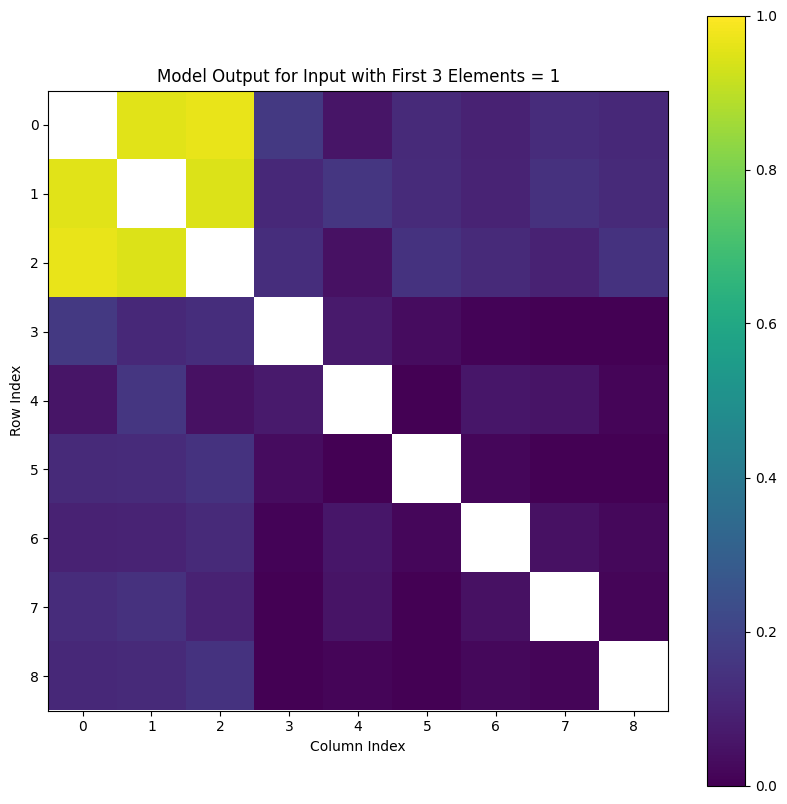

In [332]:

# Test the model
def test_model(model):
    with torch.no_grad():
        test_inputs = random_sparse_inputs(1000)
        test_outputs = model(test_inputs)
        expected_outputs = compute_expected(test_inputs)
        test_loss = weighted_loss(test_outputs, expected_outputs)
        return test_loss
    
# Compute the loss
test_loss = test_model(model)
print(f'\nTest Loss: {test_loss.item():.6f}')

def plot_output(model):
# See the output for a particular input
    with torch.no_grad():
        test_input = first_inputs()
        test_output = model(test_input)
    k2 = k * 3
    test_output_mini = test_output[0].reshape(m, m)[:k2, :k2]
    test_output_mini[range(k2), range(k2)] = float('nan')
    print(test_output_mini)
    # Visualize the test output as a heatmap, with values normalized between 0 and 1
    plt.figure(figsize=(10, 10))
    plt.imshow(test_output_mini.cpu().numpy(), cmap='viridis')
    plt.clim(0, 1)
    plt.colorbar()
    plt.title(f'Model Output for Input with First {k} Elements = 1')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

plot_output(model)

100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


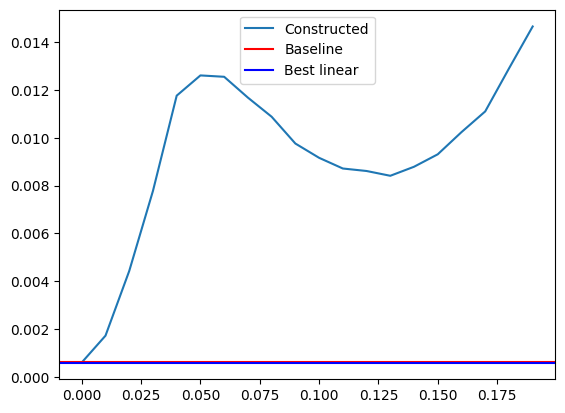

In [112]:
# Loss from a model that just outputs 0
baseline = k*(k-1)/m/m
# Loss from a model that can solve an arbitrary 2m of the m*m outputs
best_linear=(k*(k-1))/m/m * (m*m - 2*m)/m/m

# Plot loss of constructed model for different p
x = []
y = []
for p in tqdm.tqdm(torch.arange(0, 0.2, 0.01)):
    p_model = construct_model(p)
    p_test_loss = test_model(p_model)
    # print(f"{p=} {p_test_loss=}")
    x.append(p)
    y.append(p_test_loss)
plt.plot(x, y, label='Constructed')
plt.axhline(baseline, color='red', label='Baseline')
plt.axhline(best_linear, color='blue', label='Best linear')
plt.legend()
plt.show()


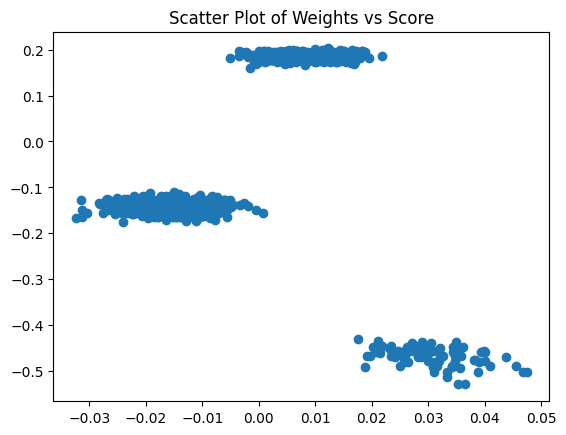

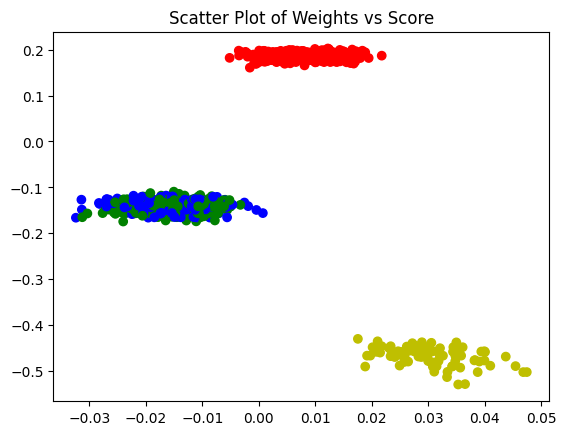

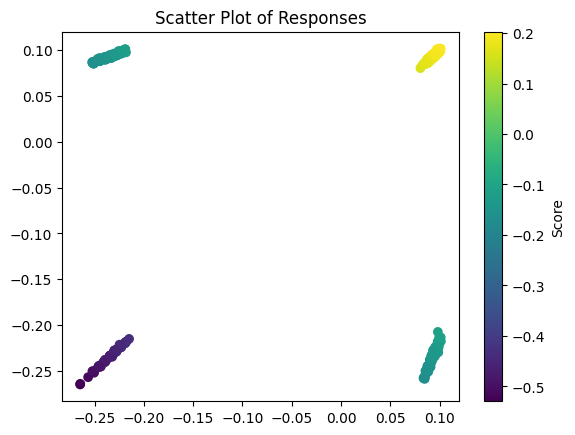

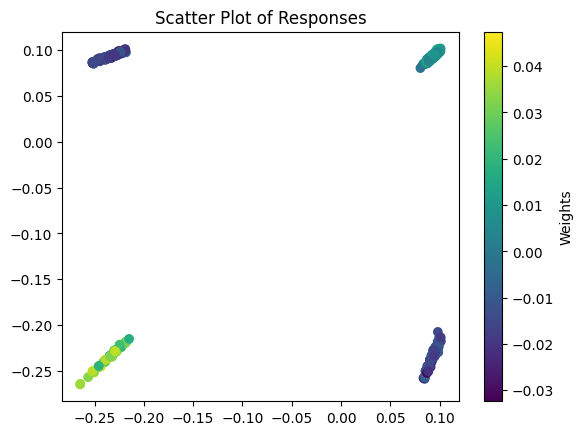

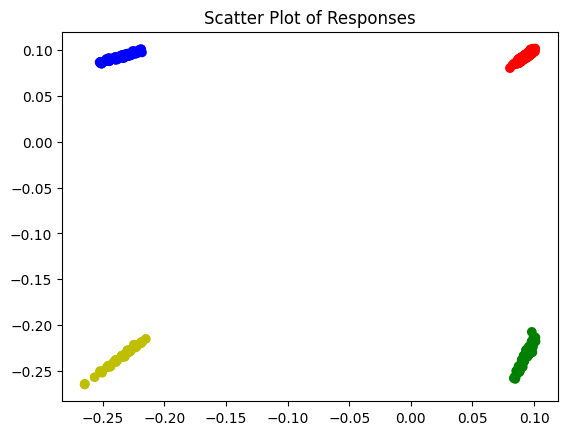

In [333]:
import numpy as np


# with torch.no_grad():
#     # Pre-relu intermidiate values under different asusmpts of the inputs
#     ints_00 = model.linear(random_first_inputs(10000, [0, 0])).mean(dim=0, keepdim=True)
#     ints_01 = model.linear(random_first_inputs(10000, [0, 1])).mean(dim=0, keepdim=True)
#     ints_10 = model.linear(random_first_inputs(10000, [1, 0])).mean(dim=0, keepdim=True)
#     ints_11 = model.linear(random_first_inputs(10000, [1, 1])).mean(dim=0, keepdim=True)


v0 = 0
v1 = 2

# How does each itnermediate value respond to each input?
resp0 = model.linear.weight[:, v0]
resp1 = model.linear.weight[:, v1]

weights = model.linear2.weight[v1*m + v0]

# Color from quadrant
colors = np.where((resp0.detach().cpu().numpy() >= 0) & (resp1.detach().cpu().numpy() >= 0), 'r', 
         np.where((resp0.detach().cpu().numpy() >= 0) & (resp1.detach().cpu().numpy() < 0), 'g', 
         np.where((resp0.detach().cpu().numpy() < 0) & (resp1.detach().cpu().numpy() >= 0), 'b', 'y')))

# Color from angle
# angle = np.arctan2(resp1.detach().cpu().numpy(), resp0.detach().cpu().numpy())
# colors = np.mod(angle, 2*np.pi) / (2*np.pi)



# colors = []
# for r1, r2 in zip(resp0[0].detach().cpu().numpy(), resp1[0].detach().cpu().numpy()):
#     top = 0.15
#     bottom = -0.08
#     r3 = (r1 + r2) / 2
#     r1 = max(min((r1 - bottom) / (top - bottom), 1), 0)
#     r2 = max(min((r2 - bottom) / (top - bottom), 1), 0)
#     r3 = max(min((r3 - bottom) / (top - bottom), 1), 0)
#     colors.append((r1, r2, r3))

score = resp0 + resp1

def fit_circular_score(resp0, resp1, weights):
    x = torch.tensor([0.0], requires_grad=True, device=device)
    y = torch.tensor([0.0], requires_grad=True, device=device)
    a = torch.tensor([-1.0], requires_grad=True, device=device)
    b = torch.tensor([0.0], requires_grad=True, device=device)
    m1 = torch.tensor([0.0], requires_grad=True, device=device)
    m2 = torch.tensor([0.0], requires_grad=True, device=device)
    optimizer = torch.optim.Adam([x, y, a, b, m1, m2], lr=0.01)
    for i in tqdm.tqdm(range(1000), desc="Fitting circular score"):
        score = torch.sqrt((resp0.detach() - x)**2 + (resp1.detach() - y)**2) * a + b + m1 * resp0 + m2 * resp1
        loss = torch.mean((score - weights.detach())**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"x={x.item():10.4f}, y={y.item():10.4f}, a={a.item():10.4f}, b={b.item():10.4f}, m1={m1.item():10.4f}, m2={m2.item():10.4f}")
    return score

#score = fit_circular_score(resp0, resp1, weights)


# plt.hist(ints_11[0].detach().cpu().numpy(), bins=50)
# plt.title('Histogram')
# plt.show()

plt.scatter(weights.detach().cpu().numpy(), score.detach().cpu().numpy())
plt.title('Scatter Plot of Weights vs Score')
plt.show()
plt.scatter(weights.detach().cpu().numpy(), score.detach().cpu().numpy(), c=colors)
plt.title('Scatter Plot of Weights vs Score')
plt.show()


plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=score.detach().cpu().numpy())
plt.colorbar(label='Score')
plt.title('Scatter Plot of Responses')
plt.show()

plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=weights.detach().cpu().numpy())
plt.colorbar(label='Weights')
plt.title('Scatter Plot of Responses')
plt.show()
plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=colors)
plt.title('Scatter Plot of Responses')
plt.show()








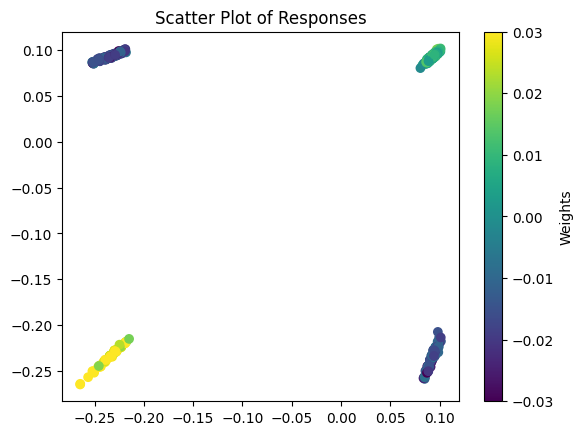

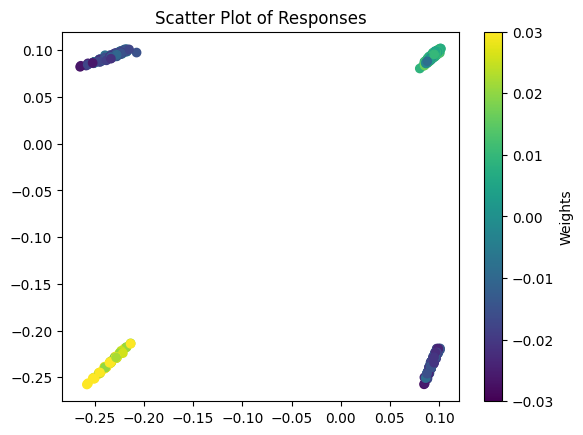

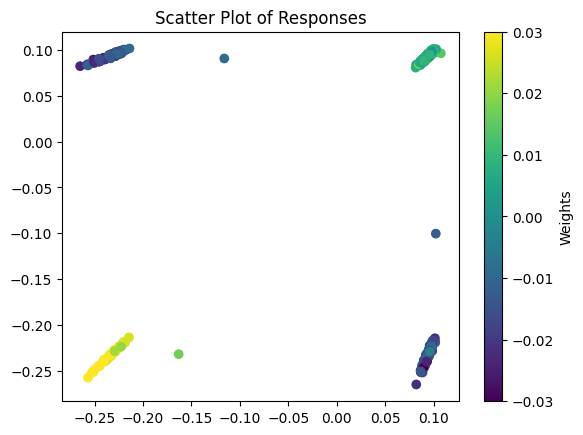

In [335]:
def scatter_plot(model, v0=0, v1=1):
    assert v0 != v1
    resp0 = model.linear.weight[:, v0]
    resp1 = model.linear.weight[:, v1]
    weights = model.linear2.weight[v1*m + v0]
    plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=weights.detach().cpu().numpy(), vmin=-0.03, vmax=0.03)
    plt.colorbar(label='Weights')
    plt.title('Scatter Plot of Responses')
    return plt
scatter_plot(model, v0, v1).show()
# scatter_plot(model, 2, 3).show()
# scatter_plot(model, 4, 5).show()



In [243]:
mask = (resp0 < -0.1) | (resp1 < -0.1)


for i, (r0, r1, w, is_masked) in sorted(enumerate(zip(resp0, resp1, weights, mask)), key=lambda x: -x[1][2].item()):
    if is_masked:
        print(f"{i}: {r0.item():10.4f}, {r1.item():10.4f}, {w.item():10.4f}")


606:    -0.1807,    -0.1809,     0.0174
67:    -0.1619,    -0.1619,     0.0124
358:    -0.1032,     0.0432,    -0.0063
279:     0.0495,    -0.1368,    -0.0107
874:    -0.1611,     0.0503,    -0.0107
723:    -0.1686,     0.0502,    -0.0107
269:     0.0507,    -0.1533,    -0.0112
394:     0.0499,    -0.1678,    -0.0115
90:     0.0497,    -0.1862,    -0.0127
962:    -0.1751,     0.0493,    -0.0128


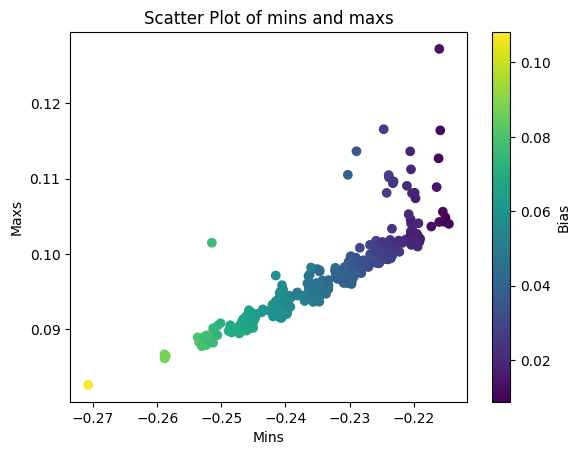

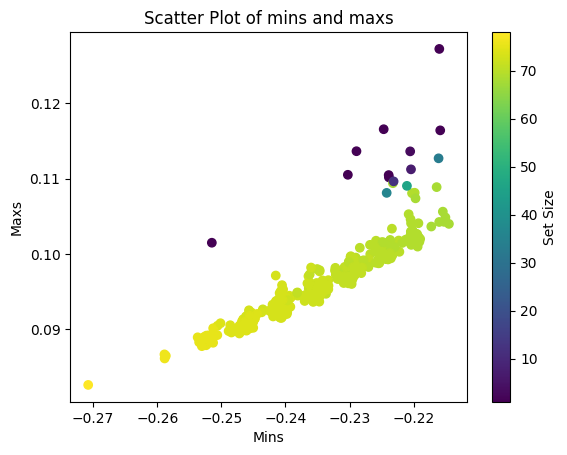

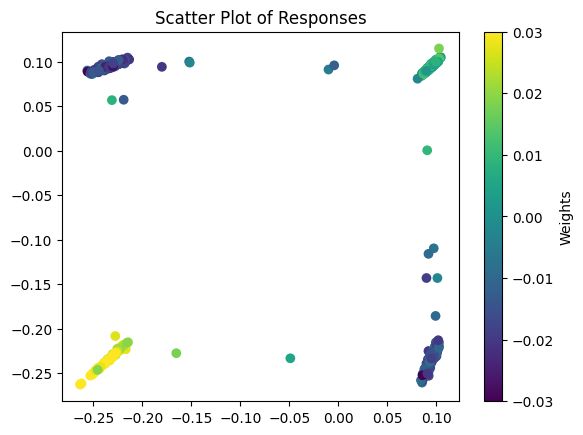

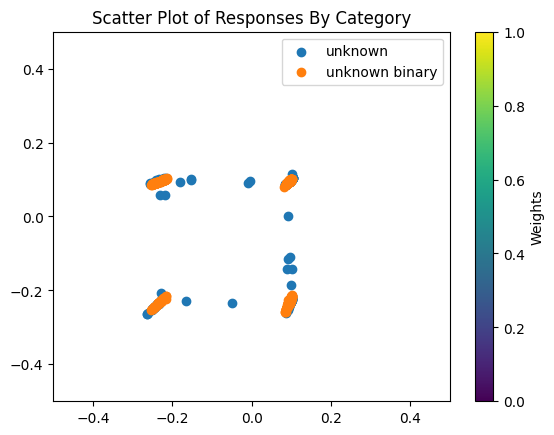

spikes 0
zero 0
C 0
B 0
unknown 495
unknown binary 505


In [327]:
# Contains -0.188 or 0.05 for every entry
model.linear.weight[606]
# Contains -0.1740 or 0.052 for every entry
model.linear.weight[999]

def is_binary(x, eps=0.05):
    a = x.min()
    b = x.max()
    is_a = (x - a).abs() < eps
    is_b = (x - b).abs() < eps
    return (is_a | is_b).all()

def is_spike(x, eps=0.05):
    a = x.min()
    b = x.max()
    is_a = (x - a).abs() < eps
    is_b = (x - b).abs() < eps
    return (is_a | is_b).all() and sum(is_b) == 1

def categorize_neuron(x):
    eps = 0.05
    a = x.min()
    b = x.max()
    is_a = (x - a).abs() < eps
    is_b = (x - b).abs() < eps
    is_binary = (is_a | is_b).all()
    if not is_binary:
        return 'unknown'
    is_spike = is_binary and sum(is_b) <= 1
    if is_spike:
        return 'spike'
    if -0.01 < a and b < 0.01:
        return 'zero'
    if 0.04 < b < 0.06 and a < -0.10:
        return 'C'
    if a > -0.10:# and 1.8 < b / a < 2.2:
        return 'B'
    return 'unknown binary'

cats = np.array([categorize_neuron(model.linear.weight[x]) for x in range(1000)])

is_binary(model.linear.weight[606])
is_binary(model.linear.weight[999])
is_bins = torch.tensor([is_binary(model.linear.weight[x]) for x in range(1000)])
is_spikes = torch.tensor([is_spike(model.linear.weight[x]) for x in range(1000)])

#print(bins)


model.linear.weight[is_bins].shape
indices = torch.where(is_bins)[0]
mins = model.linear.weight[is_bins].min(dim=1)[0]
maxs = model.linear.weight[is_bins].max(dim=1)[0]
S_size = (model.linear.weight[is_bins] > (maxs - 0.01)[:, None]).sum(dim=1)

plt.scatter(mins.detach().cpu().numpy(), maxs.detach().cpu().numpy(), c=model.linear.bias[is_bins].detach().cpu().numpy())
plt.title('Scatter Plot of mins and maxs')
plt.xlabel('Mins')
plt.ylabel('Maxs')
plt.colorbar(label='Bias')
plt.show()

plt.scatter(mins.detach().cpu().numpy(), maxs.detach().cpu().numpy(), c=S_size.detach().cpu().numpy())
plt.title('Scatter Plot of mins and maxs')
plt.xlabel('Mins')
plt.ylabel('Maxs')
plt.colorbar(label='Set Size')
plt.show()



def scatter_plot_cats(model, v0=0, v1=1):
    assert v0 != v1
    resp0 = model.linear.weight[:, v0]
    resp1 = model.linear.weight[:, v1]
    weights = model.linear2.weight[v1*m + v0]
    for cat in np.unique(cats):
        plt.scatter(resp0[cats == cat].detach().cpu().numpy(), resp1[cats == cat].detach().cpu().numpy(), label=cat)
    plt.legend()
    plt.colorbar(label='Weights')
    plt.title('Scatter Plot of Responses By Category')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    return plt
scatter_plot(model, v0, v1).show()
scatter_plot_cats(model, v0, v1).show()

# for i, cat in enumerate(cats):
#     print(f"{i}: {cat}")

for i, (a, b) in enumerate(zip(mins, maxs)):
    i = indices[i]
    # if  b < 0.01 and a > -0.01:
    if b> 1.8:
        print(f"{i}: {a.item():10.4f}, {b.item():10.4f}, {model.linear.bias[i].item():10.4f}")


# print(model.linear2.weight.abs().max(dim=0).values)
print("spikes", (cats=='spike').sum())
print("zero", (cats=='zero').sum())
print("C", (cats=='C').sum())
print("B", (cats=='B').sum())
print("unknown", (cats=='unknown').sum())
print("unknown binary", (cats=='unknown binary').sum())











In [300]:
cats=='spike'
for i, (cat, idx) in enumerate(zip(cats, model.linear.weight.max(dim=1).indices)):
    if cat == 'spike':
        print(f"{i}: {idx.item()}")


0: 29
8: 81
14: 84
15: 99
34: 35
36: 71
37: 14
38: 77
42: 50
43: 25
48: 77
50: 53
57: 96
63: 1
65: 87
70: 26
78: 12
81: 54
82: 57
87: 56
101: 14
103: 16
105: 40
115: 38
120: 8
121: 60
160: 65
161: 32
173: 47
177: 40
179: 68
180: 8
181: 33
182: 98
184: 37
187: 5
189: 19
190: 26
201: 81
203: 52
204: 5
209: 3
211: 23
212: 83
213: 18
215: 51
217: 76
220: 49
226: 48
231: 99
234: 88
251: 82
258: 29
266: 78
275: 89
277: 96
280: 89
283: 70
291: 60
298: 73
299: 75
302: 63
304: 86
307: 65
321: 44
322: 68
332: 91
334: 92
336: 85
349: 2
354: 78
355: 65
365: 82
368: 36
373: 58
381: 12
384: 51
387: 6
392: 11
395: 33
400: 20
403: 39
406: 77
414: 32
421: 41
427: 34
428: 58
437: 67
442: 55
443: 45
450: 88
451: 55
453: 54
456: 3
458: 56
462: 37
463: 44
464: 89
473: 35
478: 82
481: 74
485: 4
491: 90
497: 69
505: 49
512: 42
519: 75
522: 47
523: 63
524: 79
527: 3
533: 55
541: 93
544: 19
546: 71
547: 57
556: 69
564: 90
568: 34
576: 43
577: 38
578: 44
581: 73
585: 64
587: 20
588: 2
599: 30
615: 67
622: 86
62

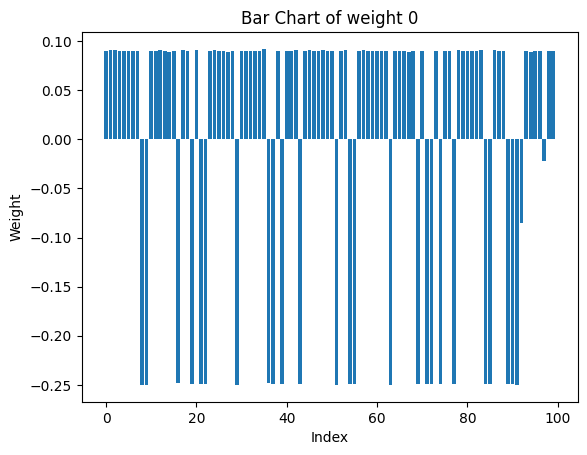

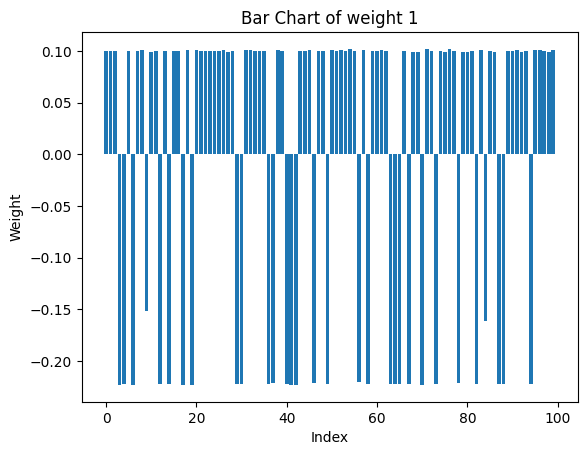

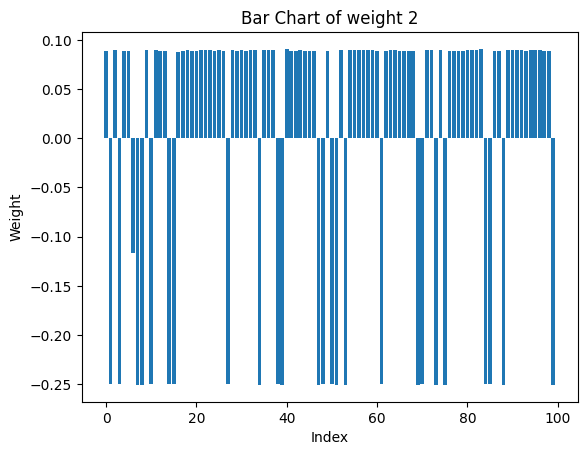

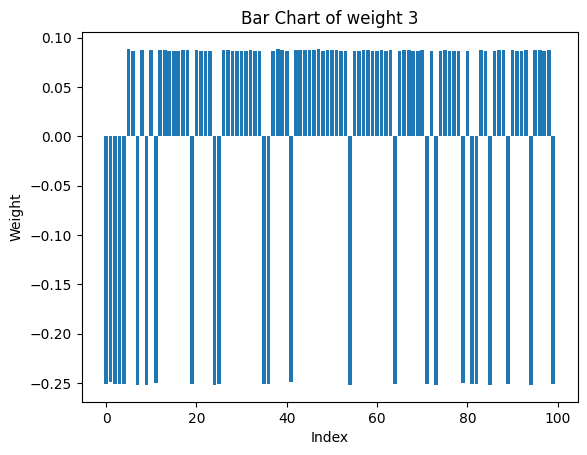

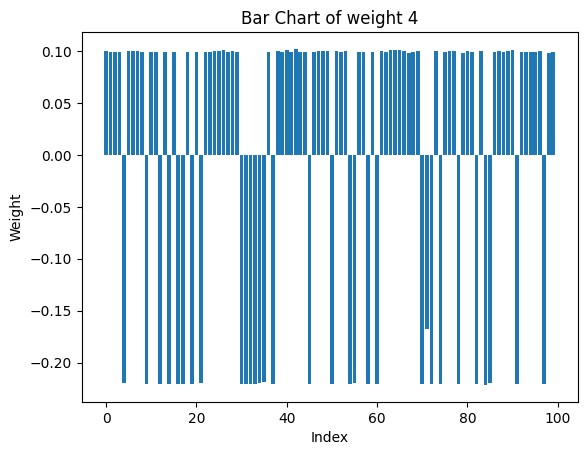

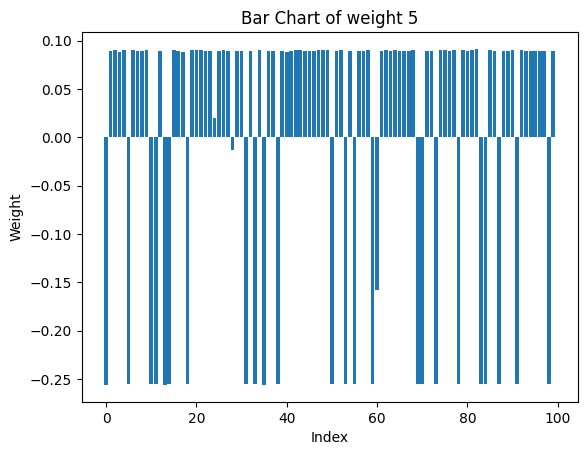

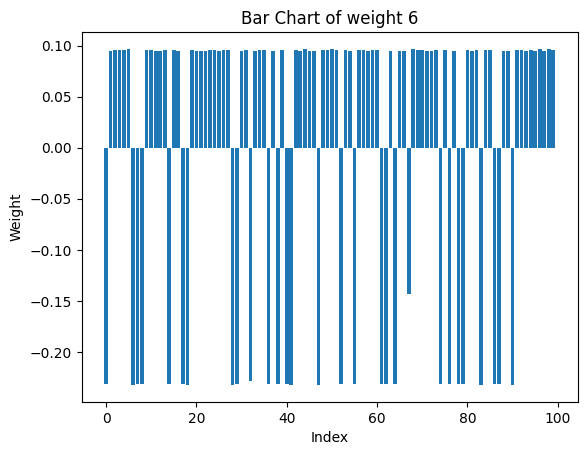

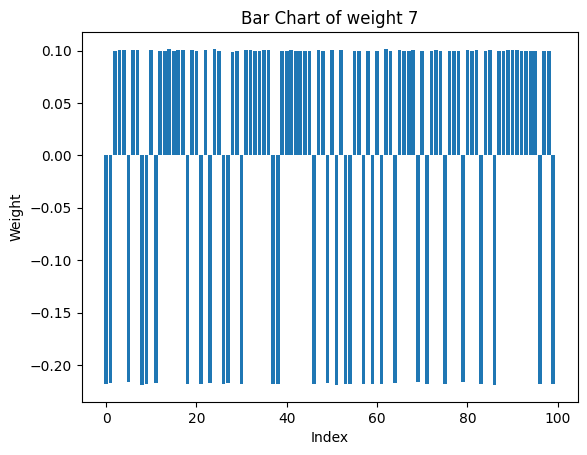

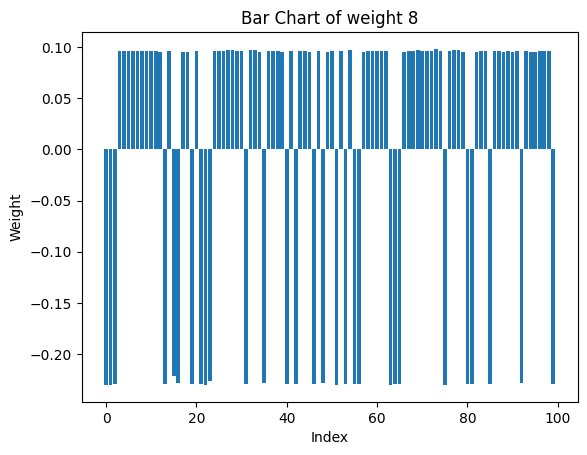

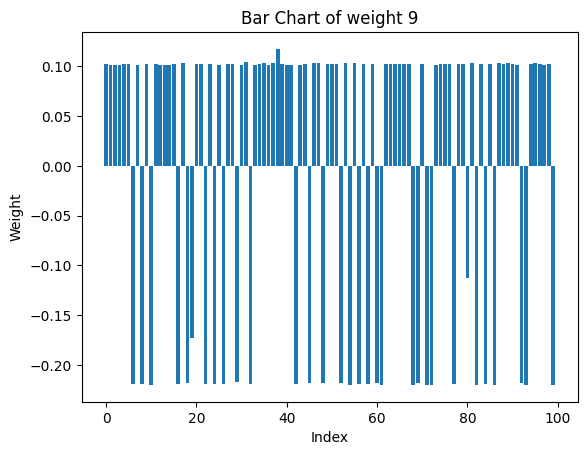

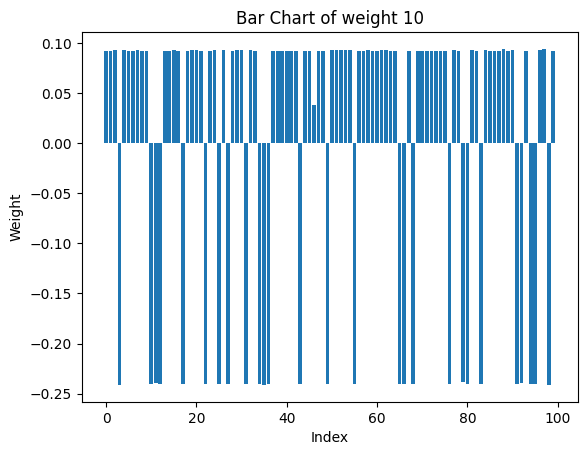

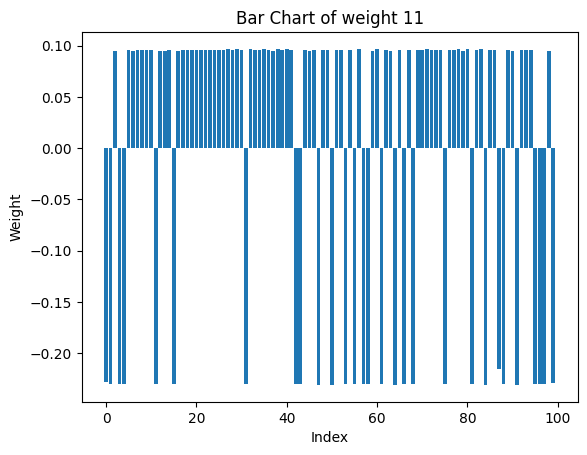

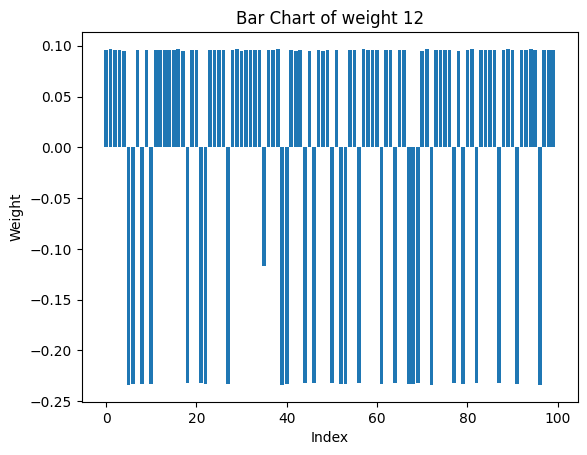

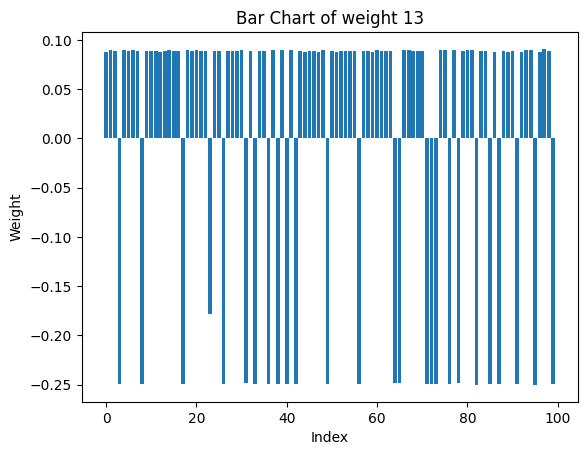

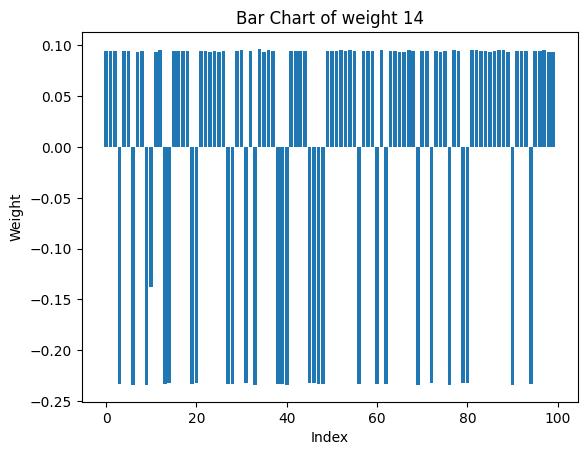

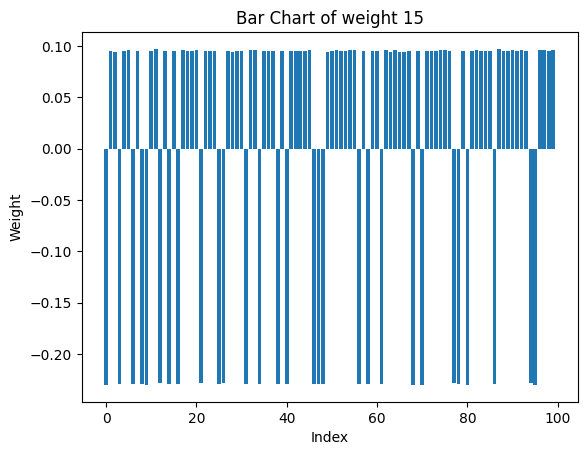

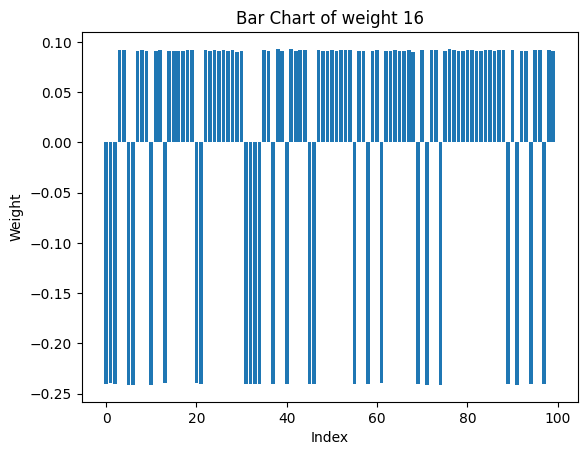

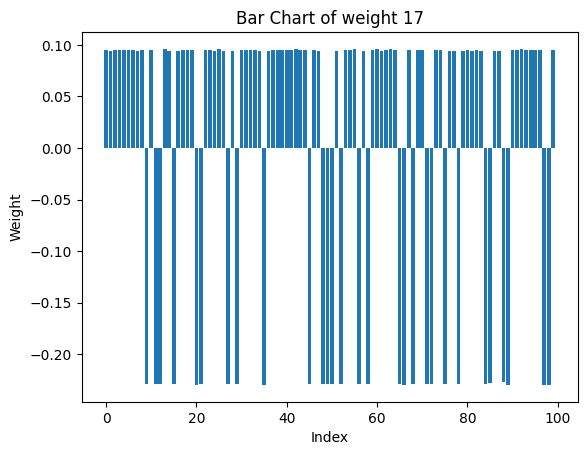

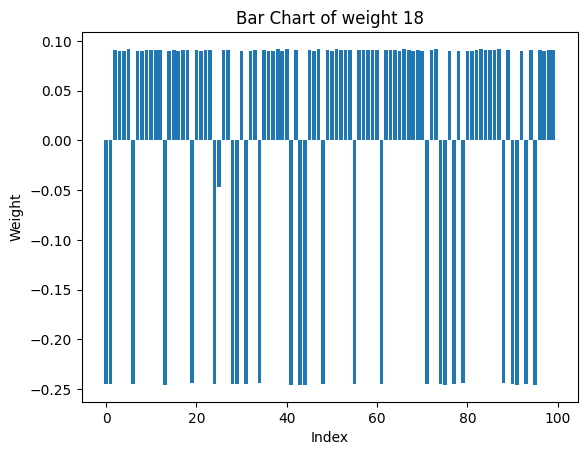

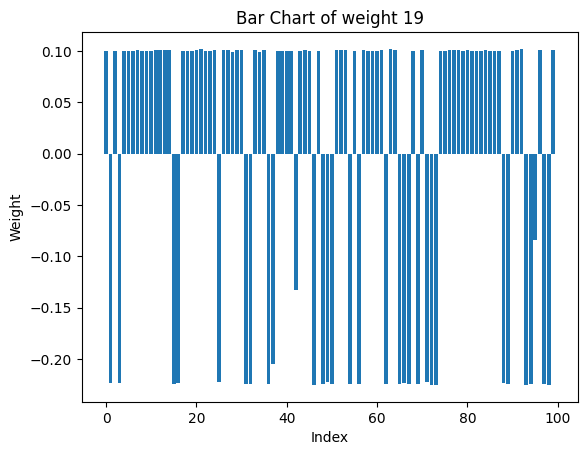

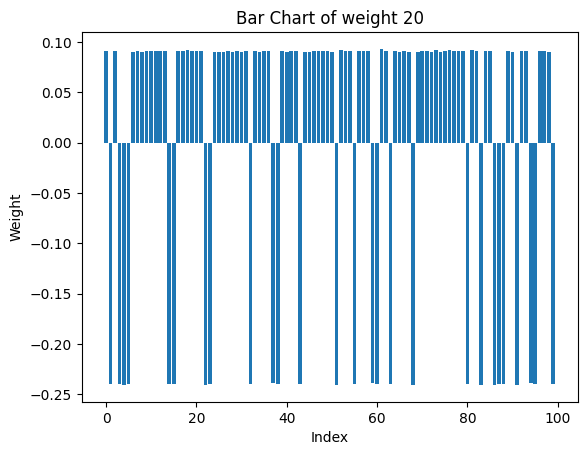

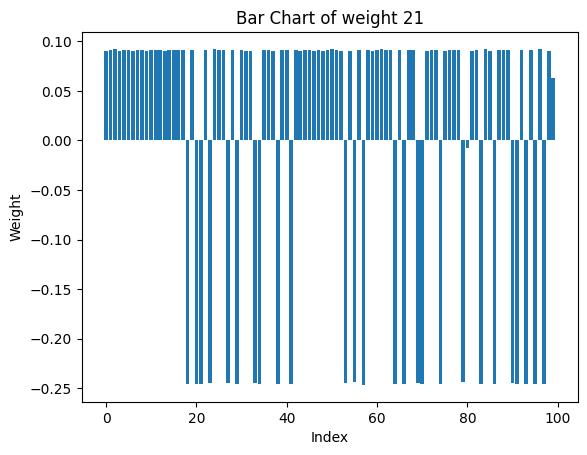

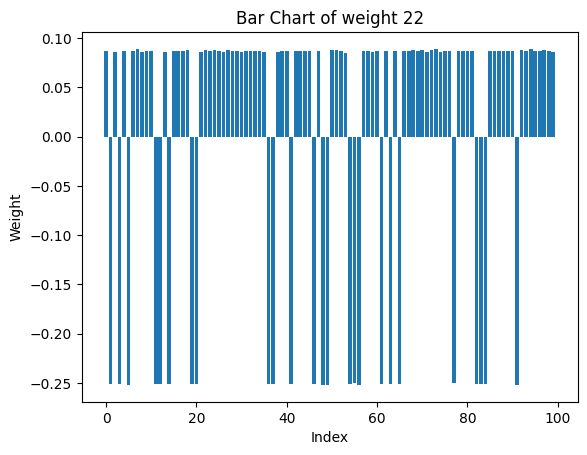

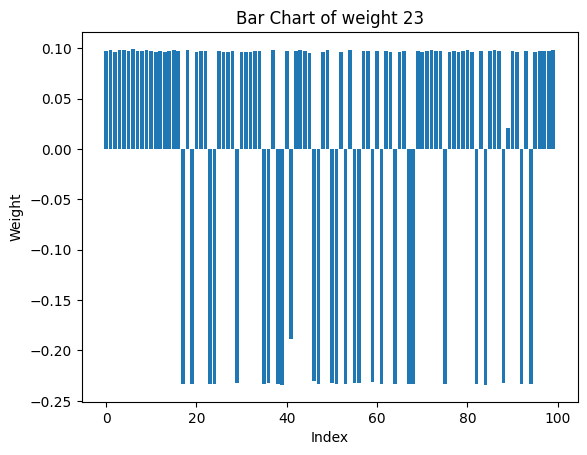

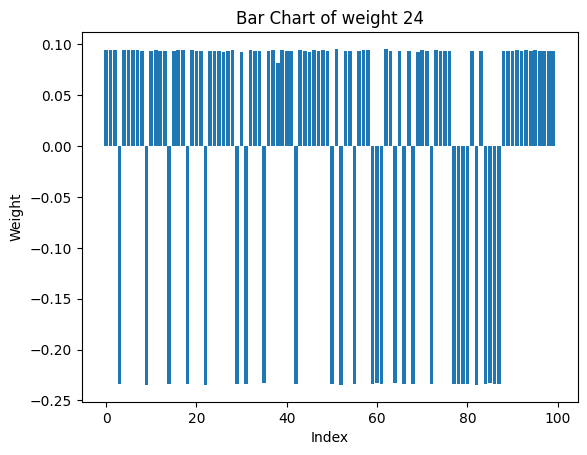

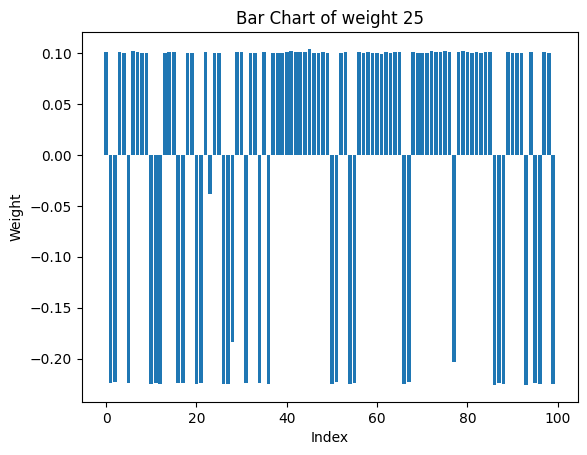

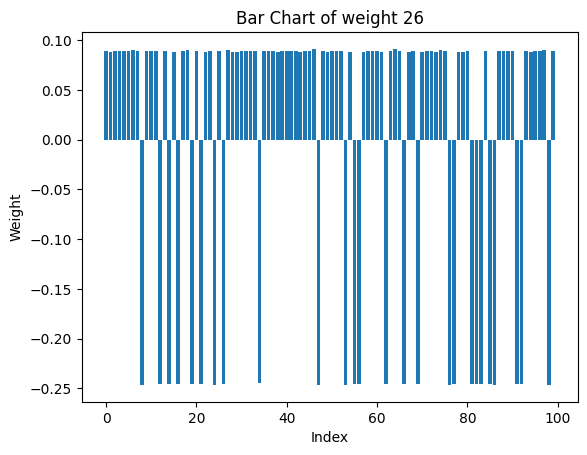

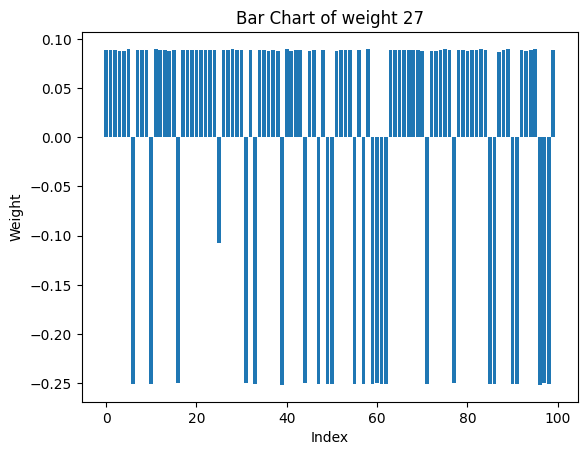

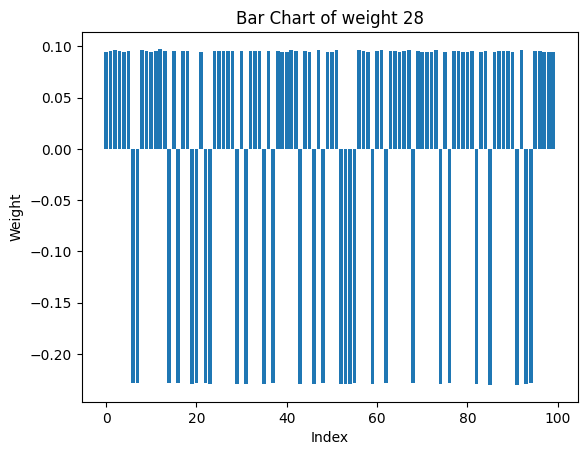

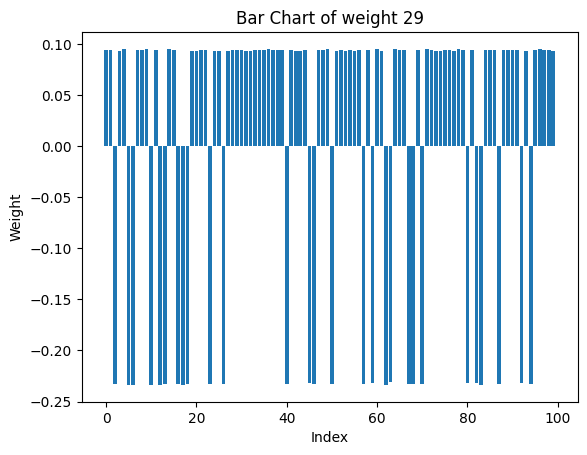

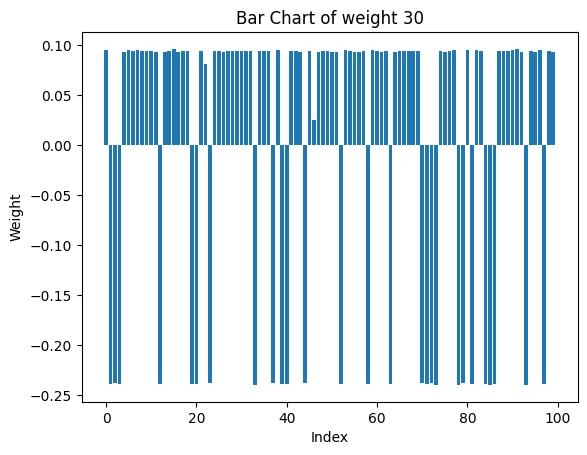

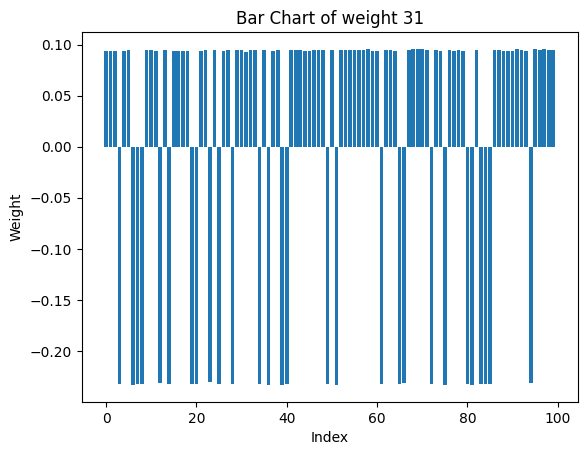

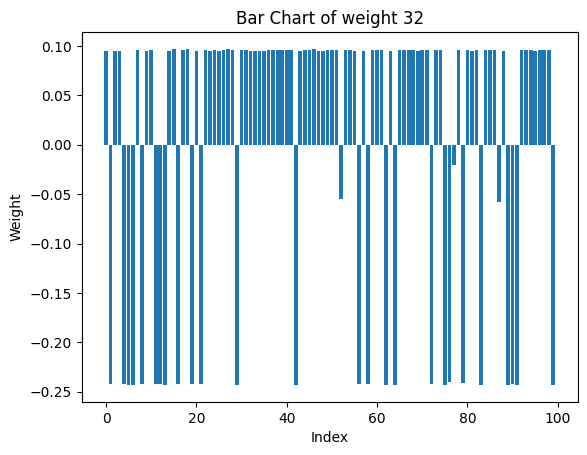

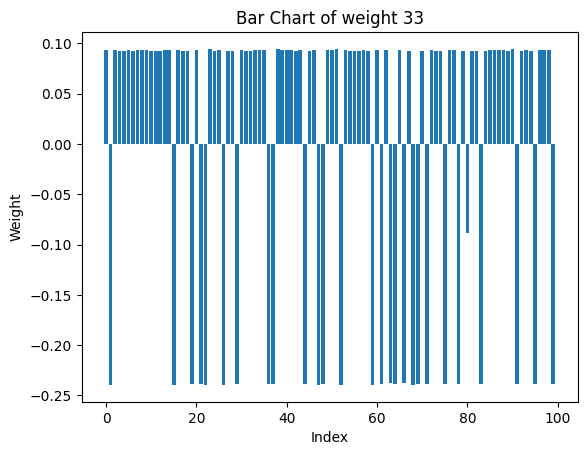

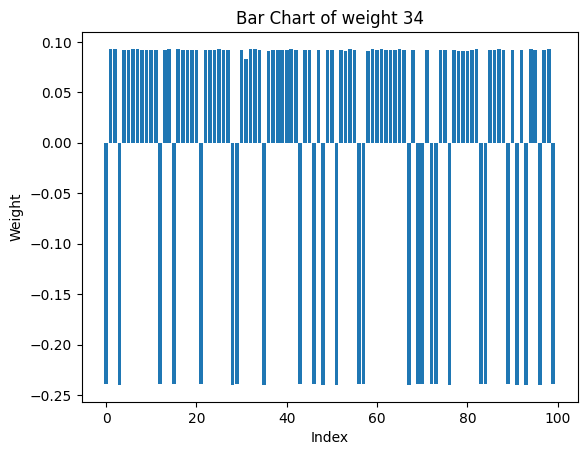

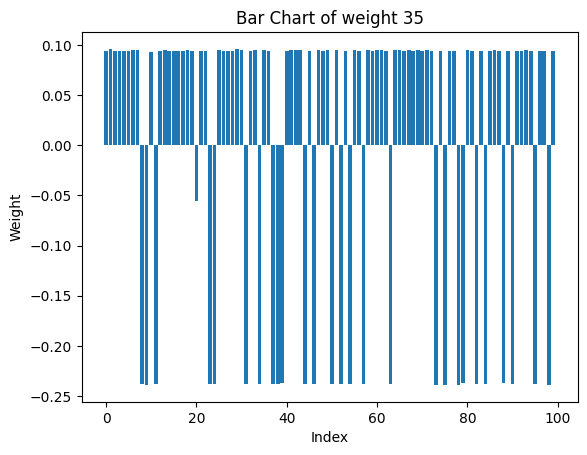

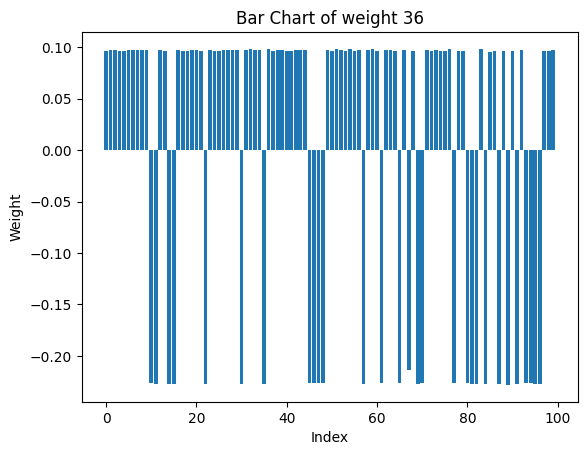

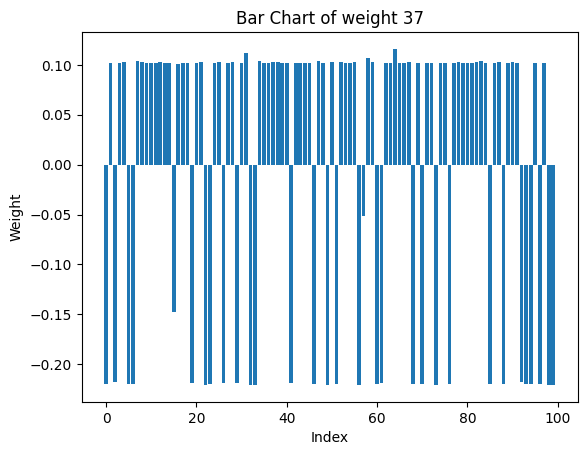

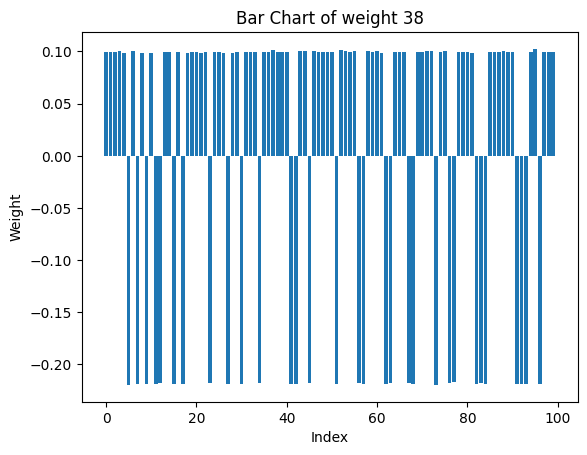

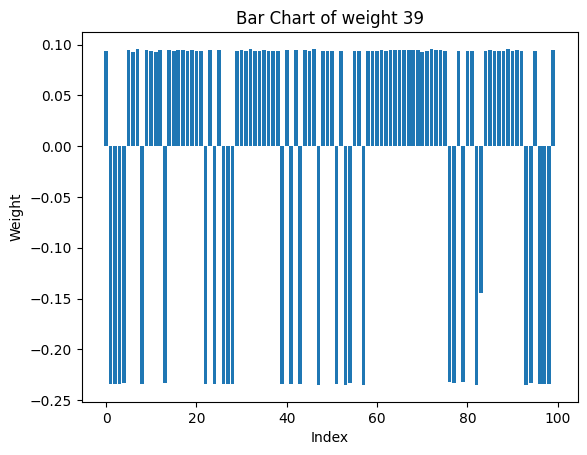

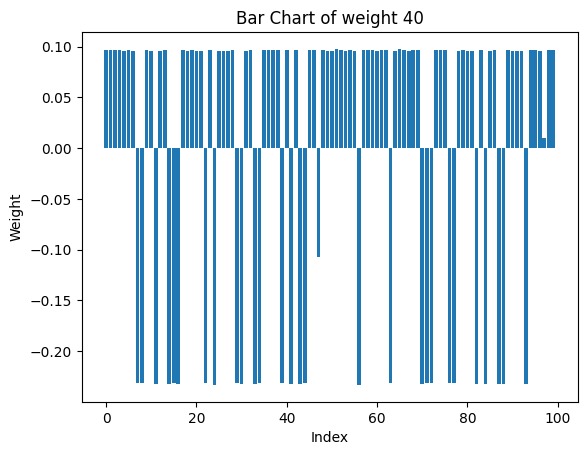

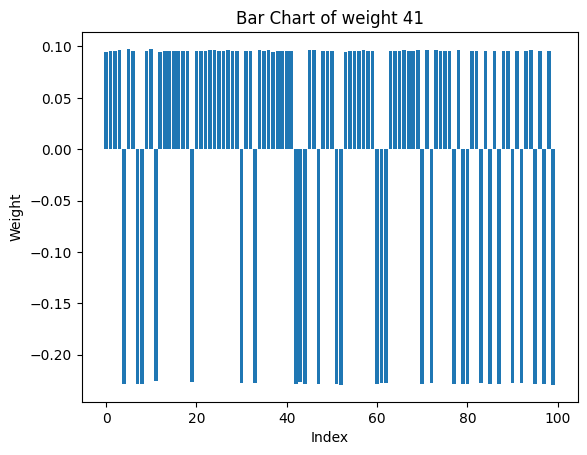

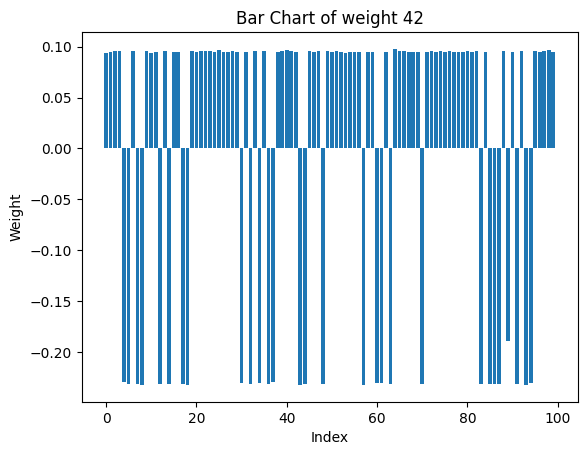

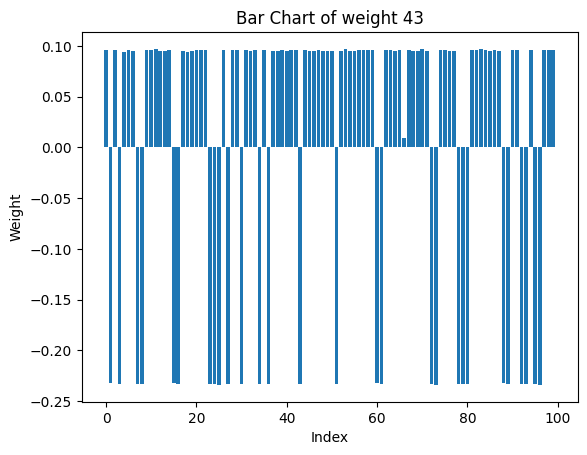

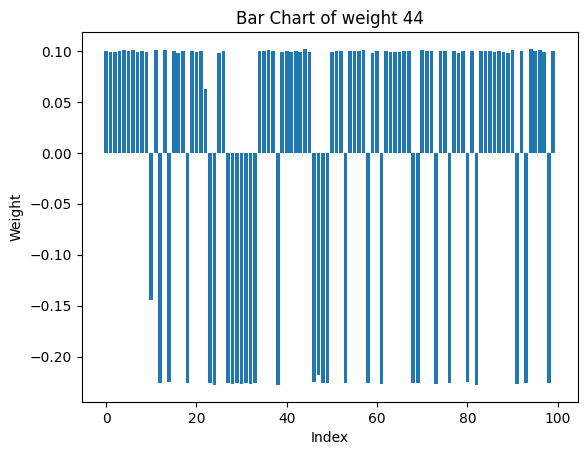

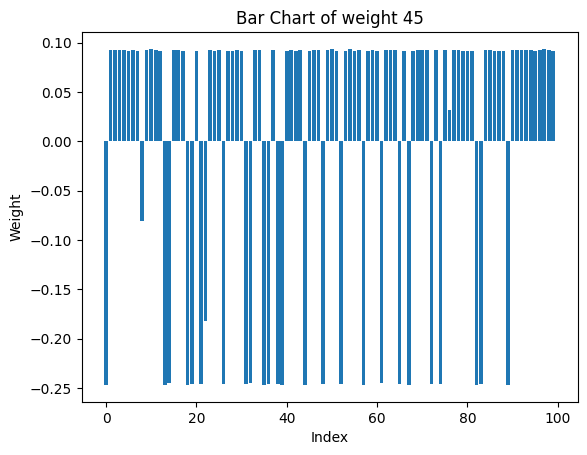

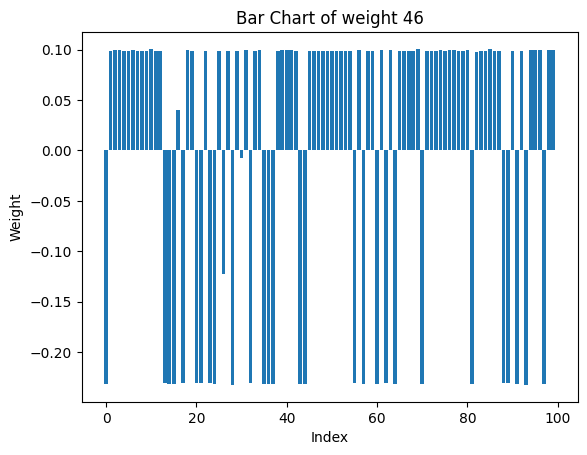

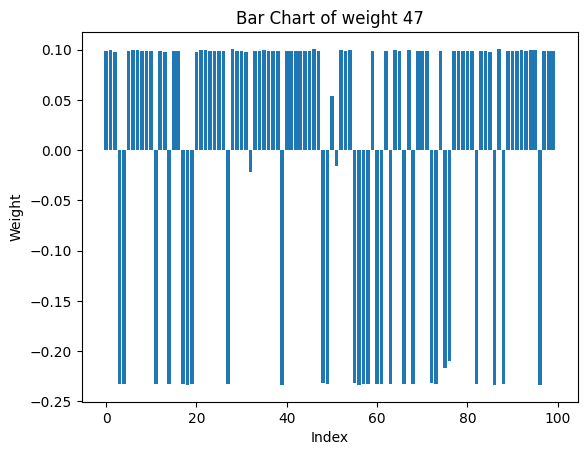

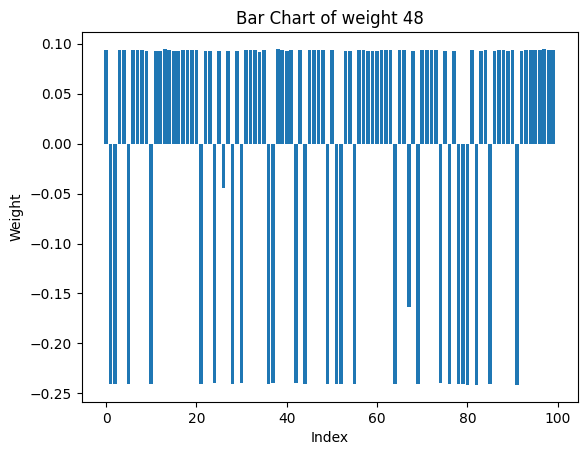

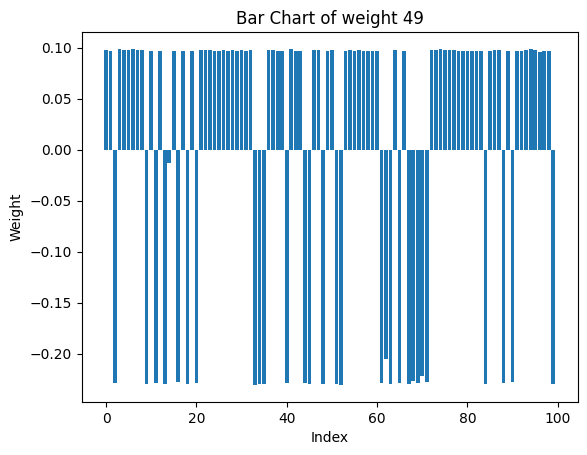

In [328]:
for i in range(50):
    if cats[i] == 'zero': continue
    plt.bar(range(len(model.linear.weight[i].detach().cpu().numpy())), model.linear.weight[i].detach().cpu().numpy())
    # plt.ylim(-0.05, 0.05)
    plt.title(f'Bar Chart of weight {i}')
    plt.xlabel('Index')
    plt.ylabel('Weight')
    plt.show()


